### Download dataset from Kaggle, fashion_mnist

todo: explain why we choose to use fashion_mnist

In [328]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

training_set = pd.read_csv('Dataset/fashion_data/fashion-mnist_train.csv')
test_set = pd.read_csv('Dataset/fashion_data/fashion-mnist_test.csv')

print(training_set.shape)
print(test_set.shape)

(60000, 785)
(10000, 785)


### Separate into X and y sets
One hot encode y_train and t_test

In [329]:
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # One hot encode
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

In [330]:
# X is pixels, y is labels

X_train, y_train = to_xy(training_set, 'label')
X_test, y_test = to_xy(test_set, 'label')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(y_test[0])

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


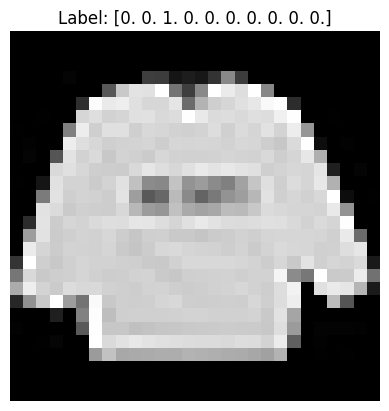

In [331]:
#visualising one image

# choosing the first image
image_array = X_train[0]
label = y_train[0]

# reshape 784 to 28x28
image_array = image_array.reshape(28, 28)

# plotting the image
plt.imshow(image_array, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [332]:
# rescaling the pixel values down to values between 0 - 1 for efficiency of neural network

X_train = X_train / 255.0
X_test = X_test / 255.0

# X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
# X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

In [333]:
# activation functions and its derivatives
class ReLU:
    def __init__(self):
        self.x_copy = None

    def forward(self, x):
        self.x_copy = x
        out = np.maximum(0, x)
        return out

    def backward(self, dout):
        #dout in: (60000, 15)
        #x_copy: (60000, 15)
        dout = dout * (self.x_copy > 0)
        #dout out: (60000, 15)
        return dout


class Sigmoid:
    def __init__(self):
        self.x_copy = None

    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        self.x_copy = x
        return self.sigmoid(x)

    def backward(self, dout):
        return self.sigmoid(self.x_copy) * (1 - self.sigmoid(self.x_copy)) * dout


class Softmax:
    def __init__(self, crossEntropy=False):
        self.x_copy = None
        self.cross_entropy = crossEntropy

    def softmax(self, x):
        stable_exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        y_prob = stable_exp_x / np.sum(stable_exp_x, axis=1, keepdims=True)
        return y_prob

    def forward(self, x):
        self.x_copy = x
        out = self.softmax(x)
        return out

    def backward(self, dout):
        if self.cross_entropy:
            return dout
        else:
            softmax_output = self.softmax(self.x_copy)
            return softmax_output * (dout - (dout * softmax_output).sum(axis=1, keepdims=True))


class Linear:
    def __init__(self, input_num, output_num, weight_init="he"):
        self.db = None
        self.dw = None
        self.rng = np.random.default_rng(42)
        # initialise weights with Xavier initialisation
        if weight_init == "he":
            self.weights = self.rng.normal(size=(input_num, output_num)) * np.sqrt(2 / input_num)
        elif weight_init == "xavier":
            self.weights = self.rng.normal(size=(input_num, output_num)) * np.sqrt(1 / input_num)
        self.bias = np.zeros((1, output_num))
        self.X_copy = None

    def forward(self, X):
        self.X_copy = X
        out = np.dot(X, self.weights) + self.bias
        return out

    def backward(self, dout):
        # Gradient with respect to weights
        dw = np.dot(self.X_copy.T, dout)  # Shape: (input_num, output_num)
        
        # Gradient with respect to biases
        db = np.sum(dout, axis=0, keepdims=True)  # Shape: (1, output_num)

        # Gradient with respect to inputs
        dx = np.dot(dout, self.weights.T)  # Shape: (batch_size, input_num)

        # Save gradients for weight and bias updates
        self.dw = dw
        self.db = db
        

        return dx

    def update_weights(self, learning_rate, l2_reg=1e-4):
        assert self.dw is not None and self.db is not None, "Gradients must be computed before updating weights"
        self.weights -= learning_rate * (self.dw + l2_reg * self.weights)
        self.bias -= learning_rate * self.db


class CrossEntropy:
    def __init__(self, softmax=False):
        self.y_pred_copy = None
        self.softmax = softmax

    def forward(self, y, y_pred):
        self.y_pred_copy = np.clip(y_pred, 1e-15, 1-1e-15)
        loss = -np.mean(np.sum(y * np.log(self.y_pred_copy), axis=1)) # axis = 1 to sum across classes
        return loss 

    def backward(self, y):
        if self.softmax:
            return self.y_pred_copy - y
        # -y / y_pred / y.shape[0]
        return np.where(y == 1, - y / (self.y_pred_copy + 1e-15) / y.shape[0], 0)

In [334]:
class NeuralNetwork:
    def __init__(self, layers, loss_fn, learning_rate):
        self.layers = layers
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        return

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self, y, y_pred):
        return self.loss_fn.forward(y, y_pred)

    def backward(self, y_train):
        grad = self.loss_fn.backward(y_train)
        for i in range(len(self.layers) - 1, -1, -1):
            grad = self.layers[i].backward(grad)

    def update(self):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.update_weights(self.learning_rate)

    def predict(self, X):
        return self.forward(X)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        correct_predictions = np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)
        accuracy = np.mean(correct_predictions)
        return accuracy

    def train(self, X_train, y_train, epochs=100):
        loss_hist = []
        for epoch in range(epochs):
            y_pred = self.forward(X_train)
            loss = self.loss(y_train, y_pred)
            if epoch % 10 == 0:
                print(f"Epoch: {epoch}, Loss: {loss}")
            loss_hist.append(loss)
            self.backward(y_train)
            self.update()
        return loss_hist

In [335]:
def plot_loss(loss_hist):
    plt.plot(loss_hist)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

### Initialising a model

In [336]:
model = NeuralNetwork(
    [
        Linear(X_train.shape[1], 400),
        ReLU(),
        Linear(400, 100),
        ReLU(),
        Linear(100,50 ),
        ReLU(),
        Linear(50, 10,weight_init="xavier"),
        Softmax(crossEntropy=True)
    ],
    CrossEntropy(softmax=True), 
    0.001)

Training model & plotting loss

In [337]:
X_train_sample = X_train
y_train_sample = y_train
loss_hist = model.train(X_train_sample, y_train_sample, epochs=100)
plot_loss(loss_hist)

Epoch: 0, Loss: 2.361940337013778
Epoch: 10, Loss: 29.71413119425427
Epoch: 20, Loss: 15.835275345796425
Epoch: 30, Loss: 14.248398670853382


KeyboardInterrupt: 

Evaluate model

In [326]:
acc = model.evaluate(X_test, y_test)
print(acc)

0.1


In [327]:
y_pred = model.predict(X_test[:5])
y = y_test[:5]
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_test[:5], axis=1)
print("Predicted classes:", predicted_classes)
print("True classes:", true_classes)

Predicted classes: [4 4 4 4 4]
True classes: [0 1 2 2 3]
